In [60]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

import matplotlib.pyplot as plt
import tikzplotlib
import pylab
from mpl_toolkits.mplot3d import Axes3D

In [61]:
# Construct model
model = Sequential()
model.add(Dense(100, input_shape=[2,], activation='selu'))
model.add(Dense(100, activation='selu'))
model.add(Dense(100, activation='selu'))
model.add(Dense(100, activation='selu'))
model.add(Dense(100, activation='selu'))
model.add(Dense(100, activation='selu'))
model.add(Flatten())
model.add(Dense(1))

In [63]:
def theta2cart(theta, r): # converts random thetas and fixed r into x and y coordinates
    x_out = tf.math.multiply(r, tf.math.cos(theta)) # x = 4cos(theta_in)
    y_out = tf.math.multiply(r, tf.math.sin(theta)) # y = 4sin(theta_in)
    
    pts = tf.transpose(tf.stack([x_out,y_out],0))
    return pts

In [64]:
def out_bnd_fn(theta_out): # f(4,theta) = 4sin(5theta)
    f_true = tf.transpose(tf.math.scalar_mul(4, tf.math.sin(tf.math.scalar_mul(5,theta_out))))
    return f_true

In [65]:
def loss_fn(model, int_pts, theta_in, theta_out): # loss_fn(model, [x,y], [theta_in], [theta_out])
    
# Find loss for interior points ###########################################################################
    with tf.GradientTape() as t:
        t.watch(int_pts)
        g = model(int_pts)
#         print('g = ', g)
    grad_g = t.gradient(g, int_pts) 
#     print(grad_g)
#     dg_dx = grad_g[0:,0,0] # dg/dx
#     print(dg_dx)
#     dg_dy = grad_g[0:,0,1] # dg/dy
    grad_g_l2_norm = tf.nn.l2_loss(grad_g) # Dirichlet energies / 2
    
# Find loss for inner boundary points #####################################################################
    in_bnd_pts = theta2cart(theta_in, 2)
    in_bnd_true = tf.zeros(tf.shape(theta_in))
    in_bnd_pred = model(in_bnd_pts) # in_bnd_err = g(x,y)-0
#     print("in_bnd_pred shape: ", tf.shape(in_bnd_pred))
    in_bnd_mse = tf.keras.metrics.mean_squared_error(in_bnd_pred, in_bnd_true) # MSE inner bound points
#     print("in_bnd_mse = ", in_bnd_mse)
    
# Find loss for outer boundary points #####################################################################    
    out_bnd_pts = theta2cart(theta_out,4)
    out_bnd_true = out_bnd_fn(theta_out)
    out_bnd_pred = model(out_bnd_pts) # MSE outer bound points
#     print("out_bnd_pred shape: ", tf.shape(out_bnd_pred))
    out_bnd_mse = tf.keras.metrics.mean_squared_error(out_bnd_pts, out_bnd_pred)
#     print("out_bnd_mse = ", out_bnd_mse)

# Find total weighted boundary error ######################################################################
    bnd_err = in_bnd_mse + out_bnd_mse
    Lambda = 100
    weighted_bnd_loss = tf.math.scalar_mul(Lambda, bnd_err)

# Total loss ##############################################################################################
    loss = tf.math.add(grad_g_l2_norm, weighted_bnd_loss)
    
    return loss

In [68]:
# Train network
def train_for():

# Define training parameters ##############################################################################    
    optimizer = tf.keras.optimizers.Ftrl() # Fancy gradient decent
    epochs = 20
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    int_pts_size = 1000 # Number of interior points to sample each iteration
    theta_in_size = 1000 # Number of inner boundary points to sample each iteration
    theta_out_size = 1000 # Number of outer boundary points to sample each iteration


    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        
        for iteration in range(iterations_per_epoch):
# Sample interior points ##################################################################################
            r_int = tf.math.sqrt( # r = sqrt(R2^2+ rand()*(R4^2-R2^2))
                tf.add(4, tf.math.scalar_mul(12, tf.random.uniform([1,int_pts_size], minval=0, maxval=1))))
            theta_int = tf.random.uniform([1,int_pts_size], minval=0, maxval=2*np.pi)
            
            # Convert to cartestian
#             x_int = tf.math.multiply(r_int, tf.math.cos(theta_int)) 
#             y_int = tf.math.multiply(r_int, tf.math.sin(theta_int))
#             int_pts = tf.transpose(tf.stack([x_int, y_int], 0))
            int_pts = theta2cart(theta_int, r_int)
    
# Sample inner bound thetas ###############################################################################    
            theta_in = tf.random.uniform([1,theta_in_size], minval=0, maxval=2*np.pi)
    
# Sample outer bound thetas ###############################################################################
            theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
            
# Optimize the network with respect to hyperparameters ####################################################
            
            with tf.GradientTape() as t:
                loss = loss_fn(model, int_pts, theta_in, theta_out) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        
        if epoch % 1 == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

In [69]:
train_for()

Epoch 000: Loss: 811.326
Epoch 001: Loss: 801.517
Epoch 002: Loss: 801.344
Epoch 003: Loss: 801.276
Epoch 004: Loss: 801.185
Epoch 005: Loss: 801.167
Epoch 006: Loss: 801.162
Epoch 007: Loss: 801.129
Epoch 008: Loss: 801.095
Epoch 009: Loss: 801.171
Epoch 010: Loss: 801.175
Epoch 011: Loss: 801.117
Epoch 012: Loss: 801.058
Epoch 013: Loss: 801.115
Epoch 014: Loss: 801.108
Epoch 015: Loss: 801.099
Epoch 016: Loss: 801.043
Epoch 017: Loss: 800.966
Epoch 018: Loss: 800.890
Epoch 019: Loss: 800.822


In [70]:
# Generate test points to plot ############################################################################
in_bnd_pts_size = 1000 # Number of inner boundary points to sample 
out_bnd_pts_size = 1000 # Number of outer boundary points to sample 
int_pts_size = 1000 # Number of interior points to sample

# Sample interior points ##################################################################################
r_int = tf.math.sqrt( # r = sqrt(R2^2+ rand()*(R4^2-R2^2))
    tf.add(4, tf.math.scalar_mul(12, tf.random.uniform([1, int_pts_size], minval = 0, maxval=1))))
theta_int = tf.random.uniform([1, int_pts_size], minval=0, maxval=2*np.pi)
# Convert to cartestian
int_pts = theta2cart(theta_int, r_int)

# Sample inner boundary points ############################################################################
theta_in = tf.random.uniform([1, in_bnd_pts_size], minval=0, maxval=2*np.pi)
in_bnd_pts = theta2cart(theta_in, 2)

# Sample outer boundary points ############################################################################
theta_out = tf.random.uniform([1, out_bnd_pts_size], minval=0, maxval=2*np.pi)
out_bnd_pts = theta2cart(theta_out, 4)
# print(out_bnd_pts.shape)
# print(out_bnd_pts)

test_pts = tf.concat([int_pts, in_bnd_pts, out_bnd_pts],0)
# print(test_pts)
print("test_pts_shape: ", test_pts.shape)

z = model(test_pts)
print("z shape: ", tf.shape(z))

test_pts_shape:  (3000, 1, 2)
z shape:  tf.Tensor([3000    1], shape=(2,), dtype=int32)


(3000,)
(3000,)
(3000,)


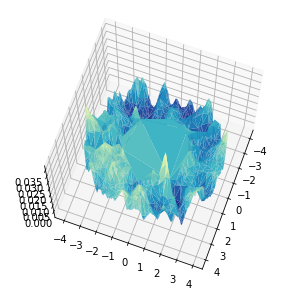

In [71]:
# Plot ####################################################################################################
fig = pylab.figure(figsize=plt.figaspect(1))
ax = Axes3D(fig)

X = test_pts[0:, 0, 0].numpy()
print(X.shape)
Y = test_pts[0:, 0, 1].numpy()
print(Y.shape)
Z = z[0:, 0].numpy()
print(Z.shape)

ax.plot_trisurf(X,Y,Z, cmap=plt.cm.YlGnBu_r)
ax.view_init(70, 20)
plt.show()

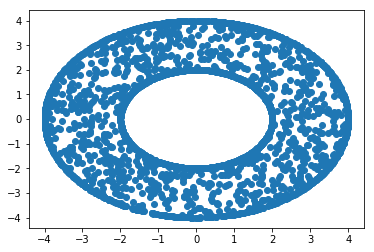

In [72]:
plt.scatter(X,Y)
plt.show()